In [52]:
import math
import numpy as np
import matplotlib.pyplot as plt
import graphviz
%matplotlib inline

In [53]:
class Value:
    def __init__(self,data,_children=(), _op='', label=''):
        self.data = data
        self.grad=0  ## initually gradiant is zero 
        self._backward = lambda: None
        self._prev=set(_children)
        self._op=_op
        self.label=label
    
    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out=Value(self.data+ other.data, (self, other),'+')
        
        def _backward():

            ''' gradient is transfered to it's children c=a+b 
                c.grad will pass to a.grad and b.grad
            '''
            self.grad+=1*out.grad
            other.grad+=1*out.grad
        out._backward=_backward
        
        
        return out
        
    
    def __mul__(self, other):
        out=Value(self.data*other.data, (self, other),'*')

        def _backward():
            ''' gradient will pass like chain rule c=a * b
                a.grad will be b * c.grad
            '''
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad  
        out._backward=_backward    
        
        return out
     
    def tanh(self):
        x=self.data
        t=(math.exp(2*x)-1)/((math.exp(2*x)+1))
        out=Value(t, (self, ), 'tanh') ## (self,) makes it a 1-element tuple, which can be iterated over later

        def _backward():
            self.grad += (1-t**2)*out.grad
        out._backward=_backward

        return out
    
    def backward(self):

        topo=[]

        visited =set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad= 1.0
        for node in reversed(topo):
            node._backward()



In [54]:
## visualization function (CP)

from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)
 
  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

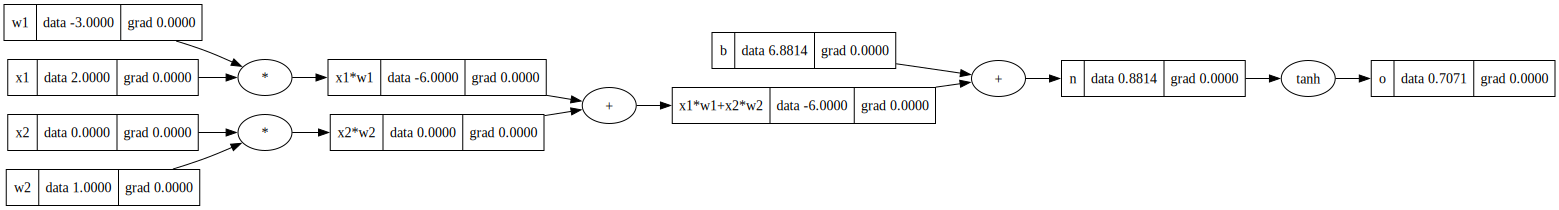

In [55]:
#x1, x2 are inputs of the neurons
x1=Value(2,label='x1')
x2=Value(0,label='x2')

## w1, w2 are weights of the neurons
w1=Value(-3,label='w1')
w2=Value(1,label='w2')


## bias for the single AN
b=Value(6.88137, label='b')


x1w1=x1*w1
x1w1.label='x1*w1'

x2w2=x2*w2
x2w2.label='x2*w2'

x1w1x2w2=x1w1+x2w2
x1w1x2w2.label='x1*w1+x2*w2'

n=x1w1x2w2+b
n.label='n'

o=n.tanh()
o.label='o'

## finally the neuron
draw_dot(o)


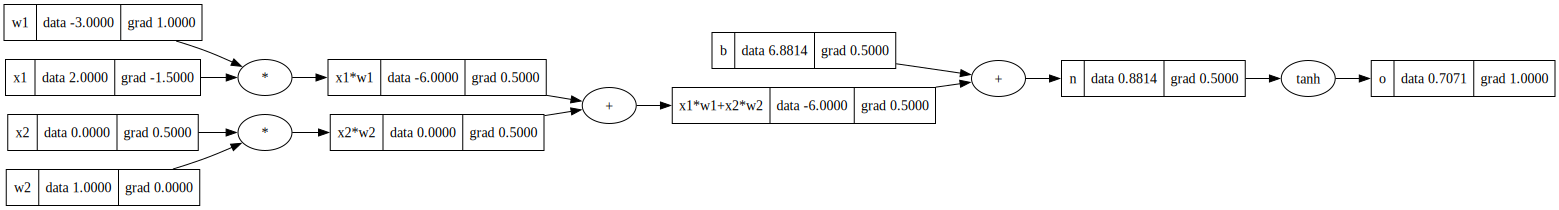

In [56]:
o.grad=1
o.backward()
draw_dot(o)